In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from scipy.stats import ttest_ind, f_oneway, anderson_ksamp, ks_2samp, linregress
from utils.fairness_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
biased_model = True

In [3]:
if biased_model == True:
    path="./data/model_output_biased.csv"
else:
    path="./data/model_output_unbiased.csv"
    
df = pd.read_csv(path)
df.head()

,Sex,Prob_default,Predicted_default,Realised_default
0,male,0.085109,0,0
1,female,0.621278,1,1
2,male,0.072370,0,0
3,male,0.650876,1,0
4,male,0.506724,1,1


# Central tendency comparison: T-test & F-test

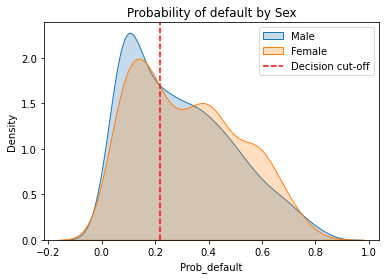

In [4]:
# plot the density plot
sns.kdeplot(df.loc[df['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df.loc[df['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add red dotted line at 0.21930892990126283
plt.axvline(x=0.21930892990126283, color='r', linestyle='--', label='Decision cut-off')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')

# display the plot
plt.show()


In [5]:
# separate the male and female groups
male = df[df['Sex'] == 'male']['Prob_default'].sort_values()
female = df[df['Sex'] == 'female']['Prob_default'].sort_values()

In [6]:
# perform t-test
t_stat, p_value = ttest_ind(male, female)
ttest_results = pd.DataFrame({'Statistic': t_stat, 'P-value': p_value}, index=['T-test'])

# perform f-test (one-way ANOVA)
f_stat, p_value = f_oneway(male, female)
anova_results = pd.DataFrame({'Statistic': f_stat, 'P-value': p_value}, index=['F-test'])

# combine the results into a single table
results_table = pd.concat([ttest_results, anova_results])

In [7]:
results_table

,Statistic,P-value
T-test,-1.906243,0.056906
F-test,3.633762,0.056906


# Distance between distributions

In [8]:
mean1 = np.mean(male)
mean2 = np.mean(female)
std1 = np.std(male, ddof=1)  # use ddof=1 for sample standard deviation
std2 = np.std(female, ddof=1)

# calculate Cohen's d
d = (mean2 - mean1) / np.sqrt((std1 ** 2 + std2 ** 2) / 2)

print("Cohen's d:", d)

Cohen's d: 0.13041623416047163


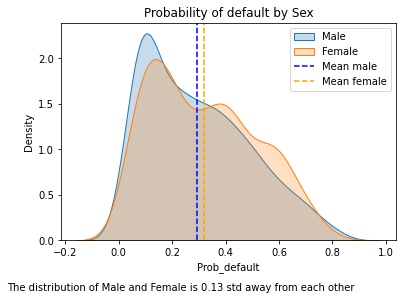

In [9]:
# plot the density plot

sns.kdeplot(df.loc[df['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df.loc[df['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add Cohen's d as a horizontal line
plt.axvline(x=mean1, label = "Mean male", color='blue', linestyle='--')
plt.axvline(x=mean2, label = "Mean female", color='orange', linestyle='--')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')
plt.figtext(0, -0.05, f'The distribution of Male and Female is {round(d, 2)} std away from each other')

# display the plot
plt.show()


# Cumulative distribution comparison

In [10]:
male, cdf_male = cdf(male) 
female, cdf_female = cdf(female)

# Perform KS test
ks_stat, ks_pvalue = ks_2samp(male, female)

# Perform Anderson-Darling test
ad_stat, ad_crit_vals, ad_sig_level = anderson_ksamp([male, female])
ad_pvalue = 1 - ad_sig_level

# Create DataFrame with test results
results = pd.DataFrame({
    'Test': ['KS test', 'Anderson-Darling test'],
    'Statistic': [ks_stat, ad_stat],
    'P-value': [ks_pvalue, ad_pvalue]
})

In [11]:
results

,Test,Statistic,P-value
0,KS test,0.086396,0.076441
1,Anderson-Darling test,2.119915,0.956428


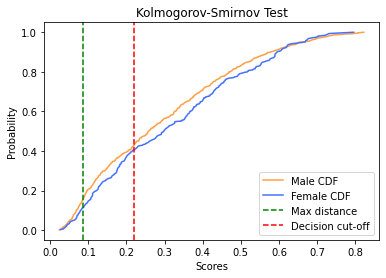

In [12]:
# Visualize CDF for each protected sub-sample
plt.plot(male, cdf_male, color = "#fea049", label="Male CDF")
plt.plot(female, cdf_female, color = "#4470ff", label="Female CDF")
plt.axvline(ks_stat, 0, 1, color="green", linestyle="dashed", label='Max distance')
plt.axvline(x=0.21930892990126283, color='r', linestyle='--', label='Decision cut-off')
plt.legend()
plt.title("Kolmogorov-Smirnov Test")
plt.xlabel("Scores")
plt.ylabel("Probability")
plt.show()

### Integral difference

In [13]:
np.trapz(y=cdf_male, x=male) - np.trapz(y=cdf_female, x=female)

0.05101075924437293

# Decile comparison in scores: PSI and Average Score Difference

In [14]:
df['Decile_rank'] = add_decile(df, 'Prob_default')
df['unique_key'] = range(0, len(df))
male_df =  df[df['Sex'] == 'male']
female_df =  df[df['Sex'] == 'female']

In [15]:
results_psi = PSI(male_df, female_df, 'Prob_default', 'unique_key')
results_psi

Prob_default_x                     unique_key_x    perc_x  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.052878  0.024592  0.073733           76  0.110145   
1                 0.088435  0.073869  0.107319           74  0.107246   
2                 0.127385  0.108335  0.151700           70  0.101449   
3                 0.177023  0.152389  0.208031           60  0.086957   
4                 0.238192  0.210715  0.269685           78  0.113043   
5                 0.307611  0.270972  0.339993           72  0.104348   
6                 0.372275  0.340205  0.402361           64  0.092754   
7                 0.443464  0.403607  0.480862           68  0.098551   
8                 0.532328  0.486986  0.588708           64  0.092754   
9                 0.679975  0.589520  0.822259           64  0.092754   

            Prob_default_y                     unique_key_y    perc_y  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.054064  0.027013  0.073598           24  0.077419   
1                 0.089608  0.073779  0.106927           26  0.083871   
2                 0.125575  0.107532  0.150048           30  0.096774   
3                 0.182678  0.152377  0.208495           40  0.129032   
4                 0.237026  0.210032  0.269881           22  0.070968   
5                 0.300750  0.273950  0.327223           28  0.090323   
6                 0.373371  0.344832  0.402826           36  0.116129   
7                 0.437485  0.402891  0.467843           32  0.103226   
8                 0.540549  0.481183  0.589346           36  0.116129   
9                 0.654282  0.589432  0.795941           36  0.116129   

                  PSI  
                       
Decile_rank            
0            0.011538  
1            0.005747  
2            0.000221  
3            0.016605  
4            0.019588  
5            0.002024  
6            0.005254  
7            0.000217  
8            0.005254  
9            0.005254

In [16]:
results_psi['PSI'].sum()

0.07170107266699434

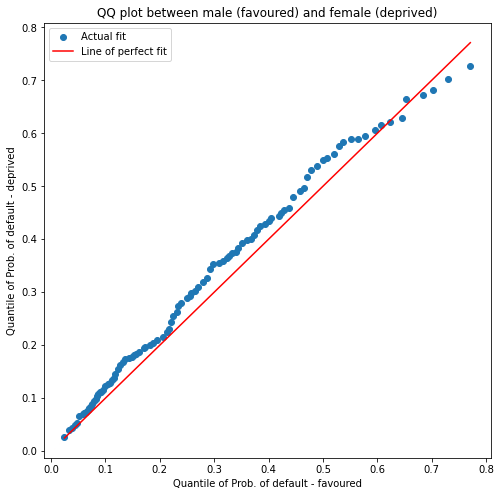

In [17]:
df_pct, linear_regression_result = score_percentile_comparison(
    df, 
    protected_variable = 'Sex', 
    score = 'Prob_default', 
    favoured_class='male', 
    deprived_class='female', 
    plot = True
)

In [18]:
df_pct

,q_deprived,q_favoured,difference
0,0.027013,0.024592,-0.002420
1,0.039023,0.032067,-0.006956
2,0.043775,0.039015,-0.004760
3,0.049879,0.044121,-0.005757
4,0.053484,0.047700,-0.005784
...,...,...,...
95,0.664903,0.653506,-0.011396
96,0.672749,0.684883,0.012134
97,0.682232,0.701658,0.019426
98,0.702324,0.729191,0.026867


In [19]:
linear_regression_result

,slope,intercept,p_value
0,0.995079,0.026906,6.266081e-104


Interpretation: On average, the percentage difference in the percentile scores of the probability of default between the favoured and deprived group is 11.7%

In [20]:
# df_pct.to_excel("./data/pct_score_difference.xlsx", index=False)